# Setting

## Library

In [2]:
import pandas as pd
import numpy as np
import math

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import random
import os
from tqdm.notebook import tqdm

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Seed

In [7]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [8]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [14]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    D = ', '.join(used)
    used += ['wml']
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [16]:
case1 = ['mvol_cum6', 'cum_winner', 'cum_loser']
df = preprocessing(df, used=case1)

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : mvol_cum6, cum_winner, cum_loser


In [17]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df

In [18]:
dynmom = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [44]:
def Roling_Windows(data, window_size, method, model):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
      'TRAIN_START_DATE':[], # 훈련 데이터 시작 지점
      'TRAIN_END_DATE':[], # 훈련 데이터 마지막 지점
      'TEST_DATE':[], # 테스트 데이터 지점
      'wml':[], # wml 값
      'dynamic_momentum':[], # 다이나믹 모멘텀 값
      'Actual_POS_WML':[], # 실제 Target 값 (0 or 1)
      'dynamic_leverage':[], # 추론된 Target 확률값
      'static_leverage':[], # 추론된 Target 값 (0 or 1)
  }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml', 'wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml', 'wml'])
    y_test = test['pos_wml'] 

    wml_test = list(test['wml'])

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['wml'].append(wml_test[0])

    dynamic_momentum = prob_test[0][-1] * wml_test[0]
    result_dict['dynamic_momentum'].append(dynamic_momentum)

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict['static_leverage'].append(pred_test[0])
    result_dict['dynamic_leverage'].append(prob_test[0][-1])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [68]:
def plot_result(data):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data['static_leverage']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data['static_leverage'])
  precision = precision_score(data['Actual_POS_WML'], data['static_leverage'])
  recall = recall_score(data['Actual_POS_WML'], data['static_leverage'])
  F1_score = f1_score(data['Actual_POS_WML'], data['static_leverage'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data['static_leverage'])
  sns.heatmap(confusion, annot=True, fmt='g')
  
  plt.show()

In [67]:
def plot_feature_importances(data):

  data = data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE', 'Actual_POS_WML',
                           'static_leverage', 'dynamic_leverage', 'cum_return',
                           'dynamic_momentum', 'wml'])

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [47]:
def display_feature_importance(data, method):
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [48]:
def slice_feature_importance(data, num):

  if type(num) != bool:
    division = int(data.shape[0]/num)
    
    for i in range(num):

      if i == num-1:
        sliced_data = data.iloc[i*division:]

      else:
        sliced_data = data.iloc[i*division:(i+1)*division]

      start = sliced_data.index[0]
      end = sliced_data.index[-1]

      print()
      print('*'*50)
      print(f'\nDATE : {start} ~ {end}\n')
      print('*'*50)
      print()
      
      plot_result(sliced_data)
      plot_feature_importances(sliced_data)
  
  else:
    start = input('Start Date (ex: 20200131): ')
    end = input('Start Date (ex: 20221230): ')
    print('*'*50)
    print(f'\nDate : {start} ~ {end}\n')
    print('*'*50)
    print()

    sliced_data = data.loc[start:end]
    plot_result(sliced_data)
    plot_feature_importances(sliced_data)

In [49]:
def cum_return_sharpe_ratio(data, dynamic=True):

  if dynamic == True:
    weight = 'dynamic_leverage'
  else:
    weight = 'static_leverage'

  # 머신러닝 적용되지 않은 경우 Sharpe Ratio
  w_S = (data['wml'].mean()/data['wml'].std()) * math.sqrt(12)
  print('ORG Sharpe Ratio : {}'.format(w_S))

  # 머신러닝 적용된 경우 Sharpe Ratio
  S = (data['dynamic_momentum'].mean()/data['dynamic_momentum'].std())*math.sqrt(12)
  print('ML Sharpe Ratio : {}\n'.format(S))
  
  # 머신러닝 적용된 경우 누적 수익률
  data['cum_return'] = (1 + data.dynamic_momentum).cumprod() - 1 

  print('\n최근 누적 수익률\n')
  latly_10 = data[['cum_return']].sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = data[['cum_return']].sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  # 머신러닝 적용되지 않은 경우 누적 수익률
  without_machine = pd.DataFrame(data['wml'])
  without_machine['wml'] = (1 + without_machine.wml).cumprod() - 1
  without_machine.columns = ['cum_return'] 

  # 머신러닝 여부에 따른 누적 수익률 비교
  plt.figure(figsize=(13, 6))
  sns.lineplot(data=data, x=data.index, y=data['cum_return'], label='With_ML')
  sns.lineplot(data=without_machine, x=without_machine.index, y=without_machine['cum_return'], label='Original')
  plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  
  plt.show()

In [50]:
def statistic_information(data, col):
  statistic = data[[col]].describe().T
  statistic['var'] = data[col].var()
  statistic['1%'] = data[col].quantile(0.01)
  statistic['99%'] = data[col].quantile(0.99)

  statistic = statistic[['count', 'mean', 'var', 'std',
                         'min', '1%', '25%', '50%',
                         '75%',  '99%', 'max']]

  return statistic

def plot_predict_result(data):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data['static_leverage']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data['static_leverage'])
  precision = precision_score(data['Actual_POS_WML'], data['static_leverage'])
  recall = recall_score(data['Actual_POS_WML'], data['static_leverage'])
  F1_score = f1_score(data['Actual_POS_WML'], data['static_leverage'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data['static_leverage'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Confusion Matrix')
  
  plt.show()

  # ACTUAL = PRED = 1
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 1\n')

  plt.title('WML in ACTUAL = PRED = 1')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  
  plt.title('Dynamic Momentum in ACTUAL = PRED = 1')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)


  print()
  print('-'*80)
  print()

  # ACTUAL = PRED = 0
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 0\n')

  plt.title('WML in ACTUAL = PRED = 0')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  
  plt.title('Dynamic Momentum in ACTUAL = PRED = 0')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 0 & PRED = 1
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = 0 & PRED = 1\n')

  plt.title('WML in ACTUAL = 0 & PRED = 1')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  
  plt.title('Dynamic Momentum in ACTUAL = 0 & PRED = 1')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 1 & PRED = 0
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = 1 &  PRED = 0\n')

  plt.title('WML in ACTUAL = 1 & PRED = 0')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  
  plt.title('Dynamic Momentum in ACTUAL = 1 & PRED = 0')
  sns.barplot(data=cond_data.sort_values(by='wml', ascending=True),
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)

In [51]:
def plot_dynamic_momentum(data):

  print('\nTop 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=False).head(5))

  print('\nBottom 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=True).head(5))
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Dynamic Momentum')
  sns.histplot(data=data, x='dynamic_momentum', kde=True)
  plt.show()
  print()

  plt.figure(figsize=(13,8))
  plt.title('Line Plot of Dynamic Momentum')
  sns.lineplot(data=data, x=data.index, y='dynamic_momentum', marker='o', markersize=5 ,linewidth=0.5)
  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[str(data.index[i])[:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=13,
                  width=5)
  plt.show()
  print()

  plt.figure(figsize=(13,8))
  plt.title('Dynamic Leverage vs. WML')
  sns.lineplot(data=data, x=data.index, y='dynamic_leverage', label='Dynamic Leverage', marker='o', markersize=5 ,linewidth=0.5)
  sns.lineplot(data=data, x=data.index, y='wml', label='WML', marker='o', markersize=5 ,linewidth=0.5)
  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[str(data.index[i])[:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=2,
                  width=5)
  plt.legend()
  plt.show()

In [52]:
def plot_trend_by_wml_leverage(Result, dynmom):
  dynmom.index.name = 'TEST_DATE'
  start_index = Result.index[0]
  dynmom = dynmom.loc[start_index:].drop(columns=['wml'])

  save_data = pd.concat([Result, dynmom], axis=1)

  trend_data = save_data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE',
                                        'Actual_POS_WML', 'static_leverage',
                                        'pos_wml', 'cum_return'])
  # WML
  print('-'*30)
  print('\nWML Positive or Negative (0)\n')
  print('-'*30)

  print('\nWML Positive\n')

  cond = (trend_data['wml']>=0)
  pn = trend_data.loc[cond]

  print('top 10 WML Positive')
  display(pn.sort_values(by='wml', ascending=False).head(10))
  print()

  print('bottom 10 WML Positive')
  display(pn.sort_values(by='wml', ascending=True).head(10))

  print()
  plt.figure(figsize=(13,8))
  plt.title('Line Plot by WML Positive')
  sns.lineplot(data=pn.drop(columns='wml'))
  plt.show()
  print()

  df_info = pd.DataFrame()
  for col in pn.drop(columns='wml').columns:
    info = statistic_information(pn, col)
    df_info = pd.concat([df_info, info])
  display(df_info)


  print('\nWML Negative\n')

  cond = (trend_data['wml']>=0)
  pn = trend_data.loc[~cond]

  print('top 10 WML Negative')
  display(pn.sort_values(by='wml', ascending=False).head(10))
  print()

  print('bottom 10 WML Negative')
  display(pn.sort_values(by='wml', ascending=True).head(10))

  print()
  plt.figure(figsize=(13,8))
  plt.title('Line Plot by WML Negative')
  sns.lineplot(data=pn.drop(columns='wml'))
  plt.show()
  print()

  df_info = pd.DataFrame()
  for col in pn.drop(columns='wml').columns:
    info = statistic_information(pn, col)
    df_info = pd.concat([df_info, info])
  display(df_info)

  # dynamic leverage
  print()
  print('-'*30)
  print('\nDynamic Leverage Positive or Negative (0.5)\n')
  print('-'*30)
  print()

  cond = (trend_data['dynamic_leverage']>=0.5)
  pn = trend_data.loc[cond]

  print('top 10 Dynamic Leverage Positive')
  display(pn.sort_values(by='dynamic_leverage', ascending=False).head(10))
  print()

  print('bottom 10 Dynamic Leverage Positive')
  display(pn.sort_values(by='dynamic_leverage', ascending=True).head(10))

  print()
  plt.figure(figsize=(13,8))
  plt.title('Line Plot by Dynamic Leverage Positive')
  sns.lineplot(data=pn.drop(columns='dynamic_leverage'))
  plt.show()
  print()

  df_info = pd.DataFrame()
  for col in pn.drop(columns='dynamic_leverage').columns:
    info = statistic_information(pn, col)
    df_info = pd.concat([df_info, info])
  display(df_info)


  print('\Dynamic Leverage Negative\n')

  cond = (trend_data['dynamic_leverage']>=0.5)
  pn = trend_data.loc[~cond]

  print('top 10 Dynamic Leverage Negative')
  display(pn.sort_values(by='dynamic_leverage', ascending=False).head(10))

  print('bottom 10 Dynamic Leverage Negative')
  display(pn.sort_values(by='dynamic_leverage', ascending=True).head(10))

  print()
  plt.figure(figsize=(13,8))
  plt.title('Line Plot by Dynamic Leverage Negative')
  sns.lineplot(data=pn.drop(columns='dynamic_leverage'))
  plt.show()
  print()

  df_info = pd.DataFrame()
  for col in pn.drop(columns='dynamic_leverage').columns:
    info = statistic_information(pn, col)
    df_info = pd.concat([df_info, info])
  display(df_info)

  # dynamic momentum
  print()
  print('-'*30)
  print('\nDynamic Momentum Positive or Negative (0)\n')
  print('-'*30)
  print()

  print('\nDynamic Momentum Positive\n')

  cond = (trend_data['dynamic_momentum']>=0)
  pn = trend_data.loc[cond]

  print('top 10 Dynamic Momentum Positive')
  display(pn.sort_values(by='dynamic_momentum', ascending=False).head(10))
  print()

  print('bottom 10 Dynamic Momentum Positive')
  display(pn.sort_values(by='dynamic_momentum', ascending=True).head(10))

  print()
  plt.figure(figsize=(13,8))
  plt.title('Line Plot by Dynamic Momentum Positive')
  sns.lineplot(data=pn.drop(columns='dynamic_momentum'))
  plt.show()
  print()

  df_info = pd.DataFrame()
  for col in pn.drop(columns='dynamic_momentum').columns:
    info = statistic_information(pn, col)
    df_info = pd.concat([df_info, info])
  display(df_info)


  print('\nDynamic Momentum Negative\n')

  cond = (trend_data['dynamic_momentum']>=0)
  pn = trend_data.loc[~cond]

  print('top 10 Dynamic Momentum Negative')
  display(pn.sort_values(by='dynamic_momentum', ascending=False).head(10))
  print()

  print('bottom 10 Dynamic Momentum Negative')
  display(pn.sort_values(by='dynamic_momentum', ascending=True).head(10))

  print()
  plt.figure(figsize=(13,8))
  plt.title('Line Plot by Dynamic Momentum Negative')
  sns.lineplot(data=pn.drop(columns='dynamic_momentum'))
  plt.show()
  print()

  df_info = pd.DataFrame()
  for col in pn.drop(columns='dynamic_momentum').columns:
    info = statistic_information(pn, col)
    df_info = pd.concat([df_info, info])
  display(df_info)

  return save_data

## Random Forest

In [53]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

In [54]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=RDF) 

**************************************************
설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]

In [55]:
Fixed_RDF_Result

,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,Actual_POS_WML,dynamic_leverage,static_leverage,mvol_cum6,cum_winner,cum_loser
TEST_DATE,,,,,,,,,,
19470731,19270730,19470630,-0.052114,-0.018240,0.0,0.35,0.0,0.310359,0.342451,0.347189
19470829,19270831,19470731,0.030634,0.016542,1.0,0.54,1.0,0.323675,0.343843,0.332482
19470930,19270930,19470829,-0.038537,-0.030830,0.0,0.80,1.0,0.315979,0.351935,0.332086
19471031,19271031,19470930,0.044931,0.022465,1.0,0.50,0.0,0.319665,0.345188,0.335147
19471129,19271130,19471031,0.053920,0.030195,1.0,0.56,1.0,0.314222,0.350699,0.335079
...,...,...,...,...,...,...,...,...,...,...
20220831,20020830,20220729,-0.021856,-0.017047,0.0,0.78,1.0,0.327036,0.329524,0.343439
20220930,20020930,20220831,0.099930,0.047966,1.0,0.48,0.0,0.329002,0.328318,0.342680
20221031,20021031,20220930,0.129322,0.108630,1.0,0.84,1.0,0.331907,0.325731,0.342362


In [56]:
-0.052114 * 0.35

-0.0182399

In [ ]:
save_data = plot_trend_by_wml_leverage(Result=Fixed_RDF_Result, dynmom=dynmom)
save_data.to_csv('/content/gdrive/MyDrive/Fin_AI/save_data/csv/Tree_Random_Forest_Case_1.csv')

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.799761339223466


최근 누적 수익률

  2022년-12월 -> 8490.57
  2022년-11월 -> 7757.31
  2022년-10월 -> 7544.45
  2022년-09월 -> 6805.10
  2022년-08월 -> 6493.58

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 8490.57
  2등 : 2002년-09월 -> 8475.99
  3등 : 2009년-02월 -> 8292.17
  4등 : 2002년-07월 -> 8061.30
  5등 : 2008년-11월 -> 7943.22
  6등 : 2002년-08월 -> 7925.82
  7등 : 2002년-06월 -> 7905.59
  8등 : 2009년-01월 -> 7866.23
  9등 : 2008년-12월 -> 7789.04
  10등 : 2022년-11월 -> 7757.31



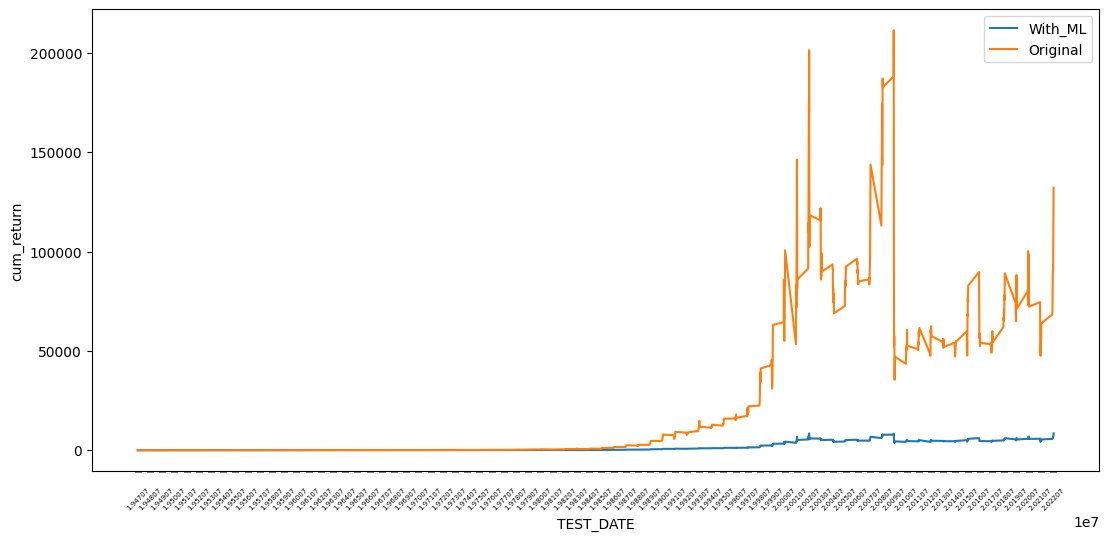

In [57]:
cum_return_sharpe_ratio(data=Fixed_RDF_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.25      0.30       316
         1.0       0.65      0.75      0.70       590

    accuracy                           0.58       906
   macro avg       0.50      0.50      0.50       906
weighted avg       0.55      0.58      0.56       906


accuracy : 0.5783664459161147

precision : 0.6529411764705882

recall : 0.752542372881356

F1-Score : 0.6992125984251969



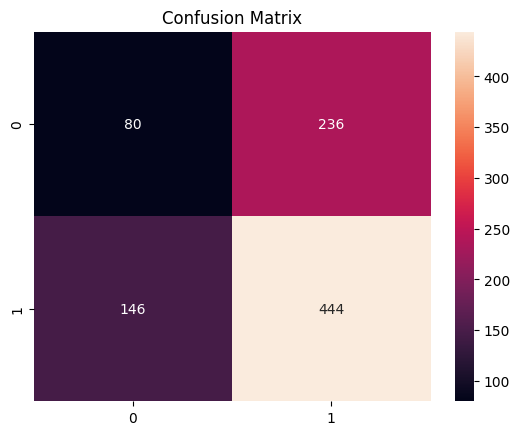


ACTUAL = PRED = 1



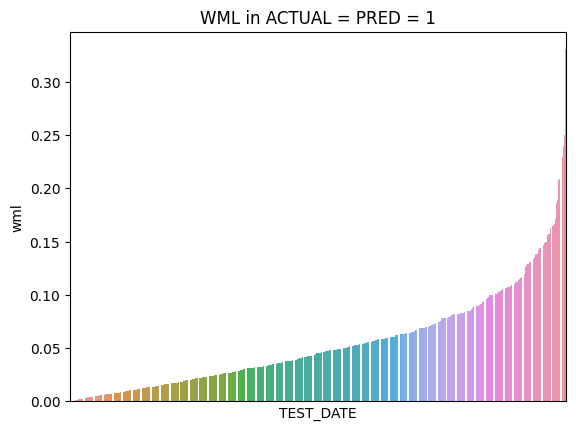

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,444.0,0.055006,0.002128,0.046131,0.000128,0.001151,0.021416,0.04509,0.077301,0.213509,0.330163


,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,444.0,0.040086,0.001216,0.034868,0.000112,0.000785,0.01473,0.031105,0.056241,0.153764,0.254225



--------------------------------------------------------------------------------


ACTUAL = PRED = 0



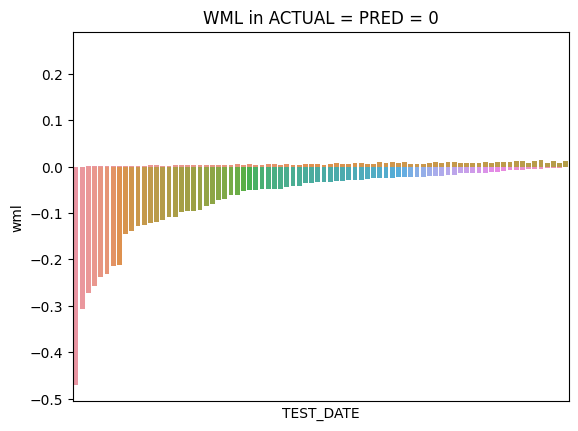

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,80.0,-0.067374,0.006827,0.082627,-0.469903,-0.340412,-0.094524,-0.033258,-0.01924,-0.002248,-0.001641


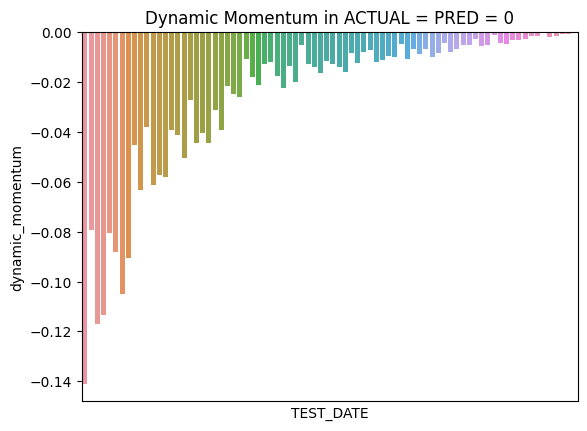

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,80.0,-0.025451,0.000944,0.030723,-0.140971,-0.121992,-0.038479,-0.012451,-0.005435,-0.000601,-0.00058



--------------------------------------------------------------------------------


ACTUAL = 0 & PRED = 1



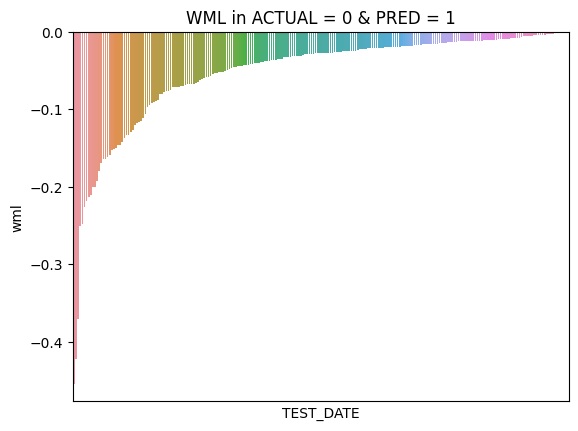

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,236.0,-0.052561,0.004451,0.066716,-0.454349,-0.328291,-0.065239,-0.027349,-0.0141,-0.000664,-0.000132


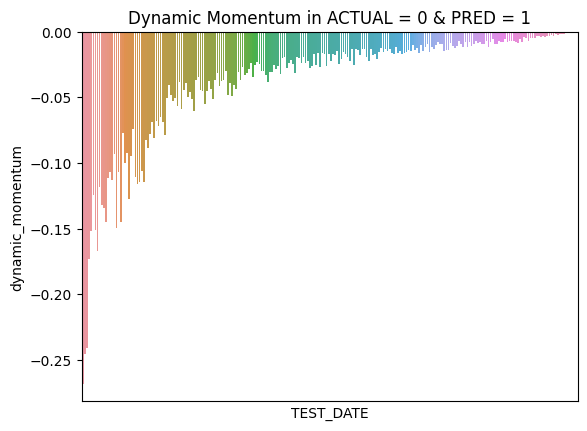

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,236.0,-0.036515,0.001936,0.043996,-0.268066,-0.2169,-0.043352,-0.019191,-0.010186,-0.000416,-0.000081



--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



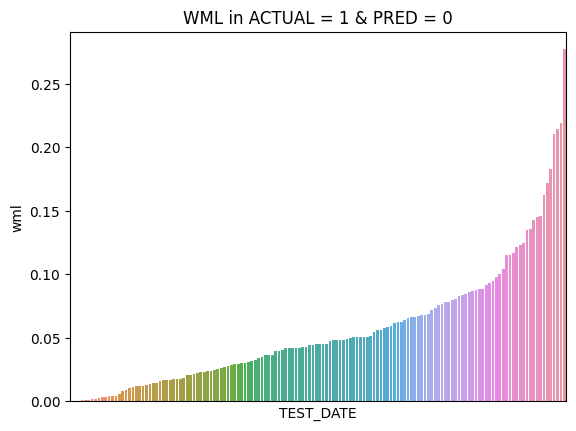

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,146.0,0.055992,0.002399,0.048977,0.000007,0.000629,0.021976,0.045066,0.076363,0.216764,0.276912


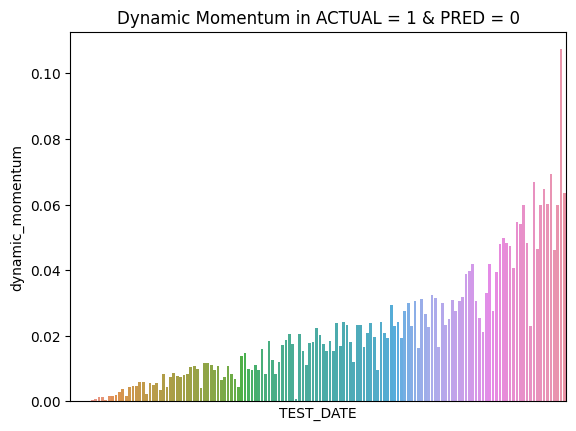

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,146.0,0.020809,0.00033,0.018175,0.000003,0.000177,0.007831,0.017359,0.027627,0.068292,0.107316


In [58]:
plot_predict_result(Fixed_RDF_Result)


Top 5 dyn_mom



,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,Actual_POS_WML,dynamic_leverage,static_leverage,mvol_cum6,cum_winner,cum_loser,cum_return
TEST_DATE,,,,,,,,,,,
20000229,19800229,20000131,0.330163,0.254225,1.0,0.77,1.0,0.356721,0.306746,0.336533,4150.221931
20020228,19820226,20020131,0.250175,0.217653,1.0,0.87,1.0,0.339382,0.320524,0.340095,6619.795164
19991231,19791231,19991130,0.239571,0.194052,1.0,0.81,1.0,0.350607,0.310712,0.338680,3251.654922
19801128,19601130,19801031,0.186602,0.162343,1.0,0.87,1.0,0.333296,0.333679,0.333025,79.764215
19820630,19620629,19820528,0.157135,0.155563,1.0,0.99,1.0,0.354931,0.320051,0.325017,94.606241



Bottom 5 dyn_mom



,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,Actual_POS_WML,dynamic_leverage,static_leverage,mvol_cum6,cum_winner,cum_loser,cum_return
TEST_DATE,,,,,,,,,,,
20090430,19890428,20090331,-0.454349,-0.268066,0.0,0.59,1.0,0.339427,0.332127,0.328446,4581.941059
20090331,19890331,20090227,-0.422400,-0.244992,0.0,0.58,1.0,0.323004,0.337493,0.339503,6260.412725
20021129,19821130,20021031,-0.370041,-0.240526,0.0,0.65,1.0,0.342984,0.320580,0.336436,5504.436107
20011031,19811030,20010928,-0.250756,-0.173022,0.0,0.69,1.0,0.340184,0.325845,0.333971,5587.727458
20120131,19920131,20111230,-0.213660,-0.166655,0.0,0.78,1.0,0.322106,0.336911,0.340983,4231.250013


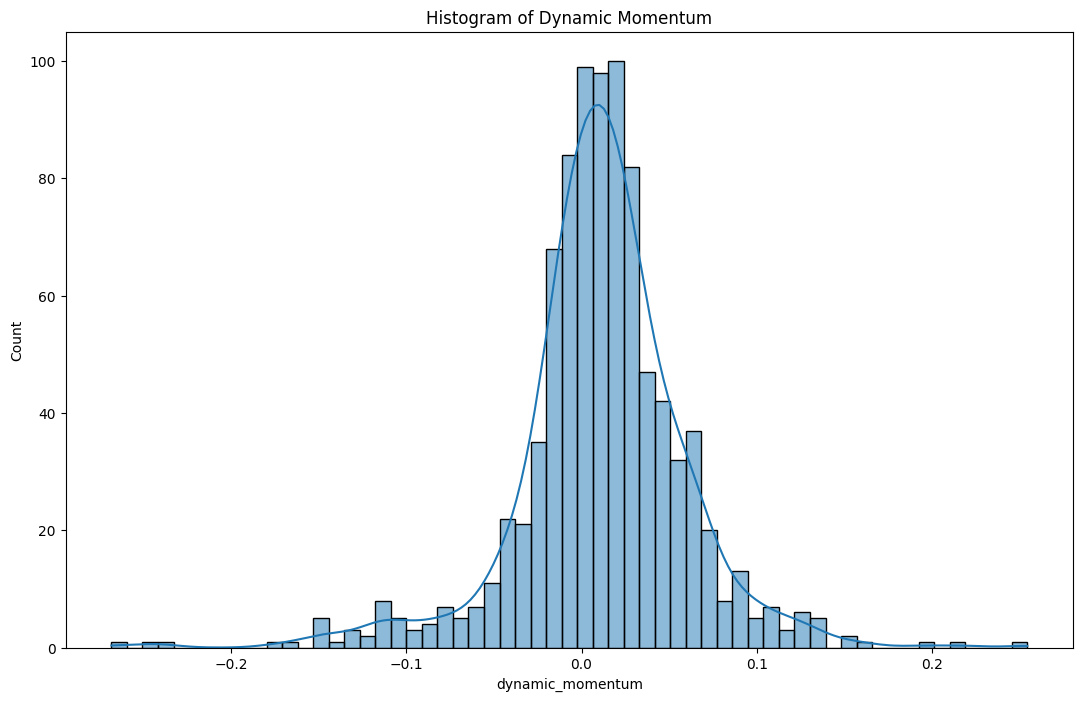

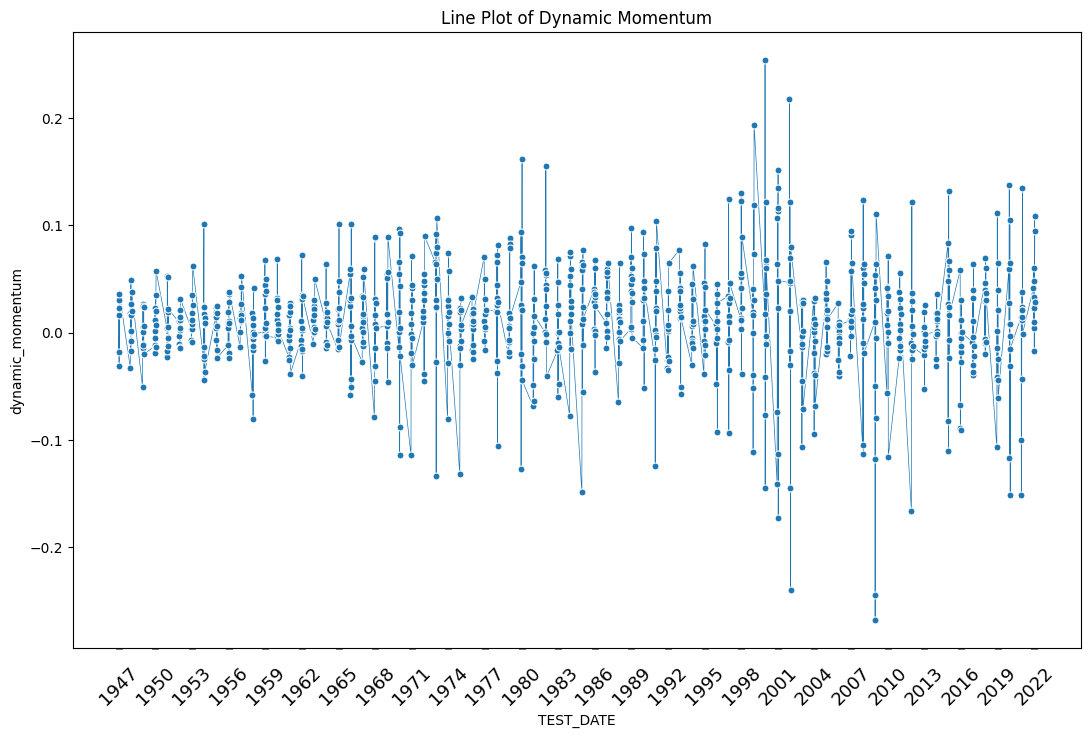

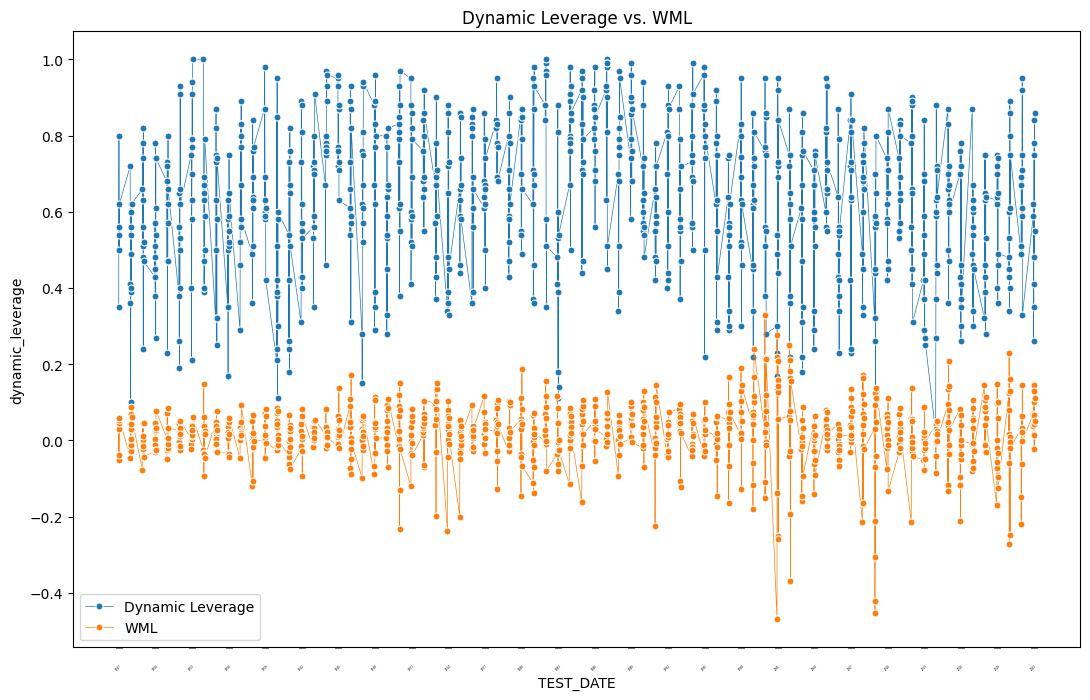

In [59]:
plot_dynamic_momentum(Fixed_RDF_Result)


Feature Importance of the model



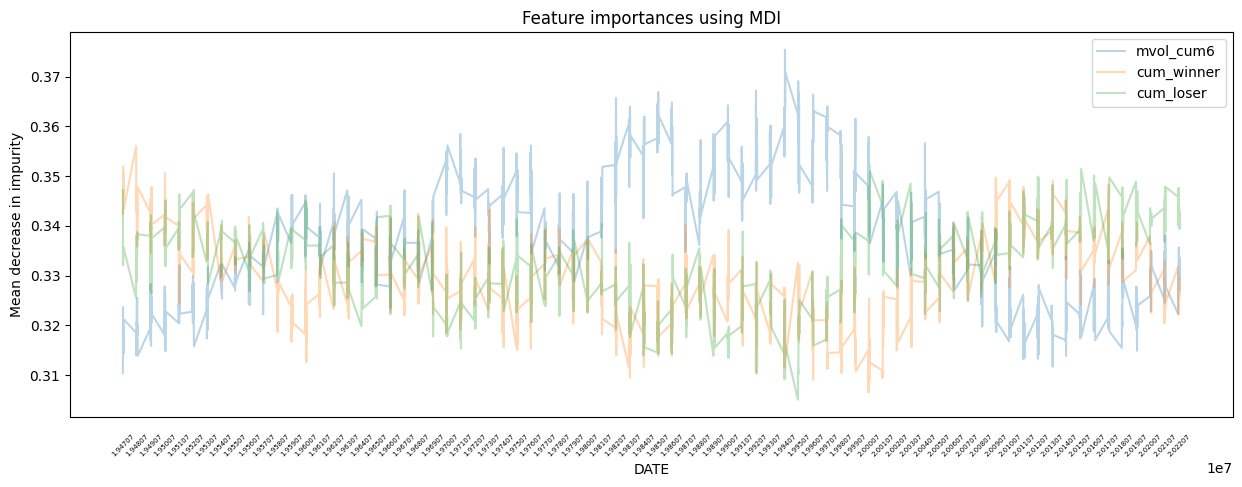

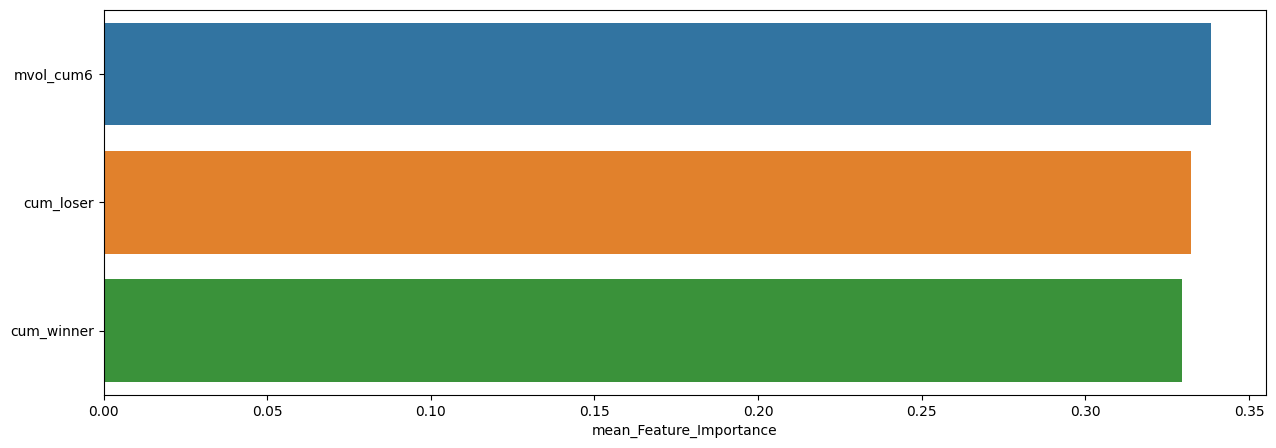

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_cum6,0.338323,0.375425,0.310359
cum_loser,0.332154,0.351433,0.305015
cum_winner,0.329524,0.356004,0.306459


In [62]:
plot_feature_importances(Fixed_RDF_Result)


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.31      0.34        75
         1.0       0.68      0.74      0.71       151

    accuracy                           0.60       226
   macro avg       0.53      0.52      0.52       226
weighted avg       0.58      0.60      0.59       226


accuracy : 0.5973451327433629

precision : 0.6829268292682927

recall : 0.7417218543046358

F1-Score : 0.7111111111111112



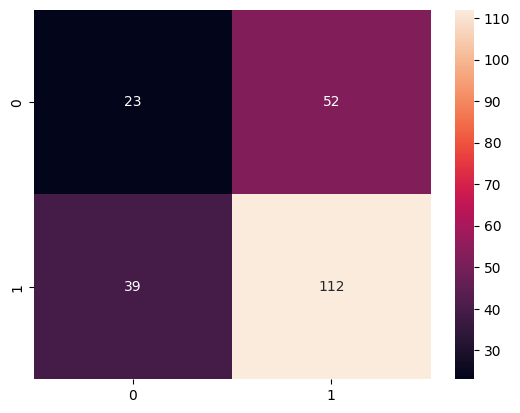


Feature Importance of the model



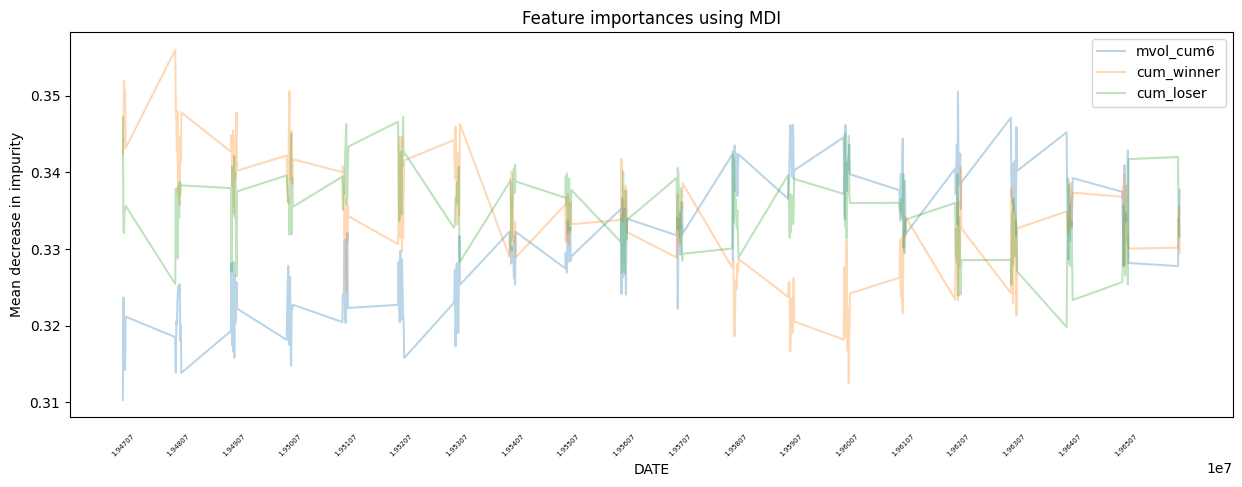

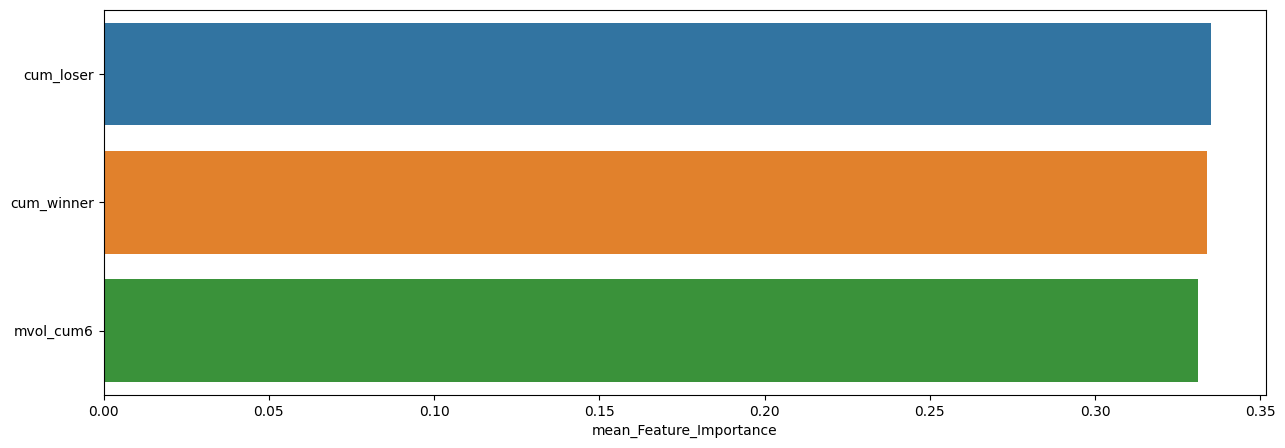

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
cum_loser,0.335002,0.347225,0.319836
cum_winner,0.333755,0.356004,0.312565
mvol_cum6,0.331243,0.350550,0.310359



**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.23      0.29        75
         1.0       0.68      0.82      0.74       151

    accuracy                           0.62       226
   macro avg       0.53      0.52      0.52       226
weighted avg       0.58      0.62      0.59       226


accuracy : 0.6238938053097345

precision : 0.6813186813186813

recall : 0.8211920529801324

F1-Score : 0.7447447447447448



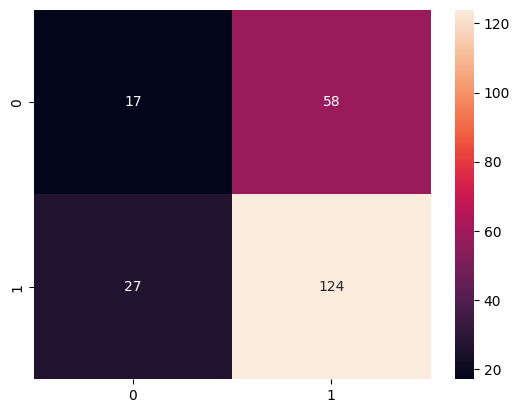


Feature Importance of the model



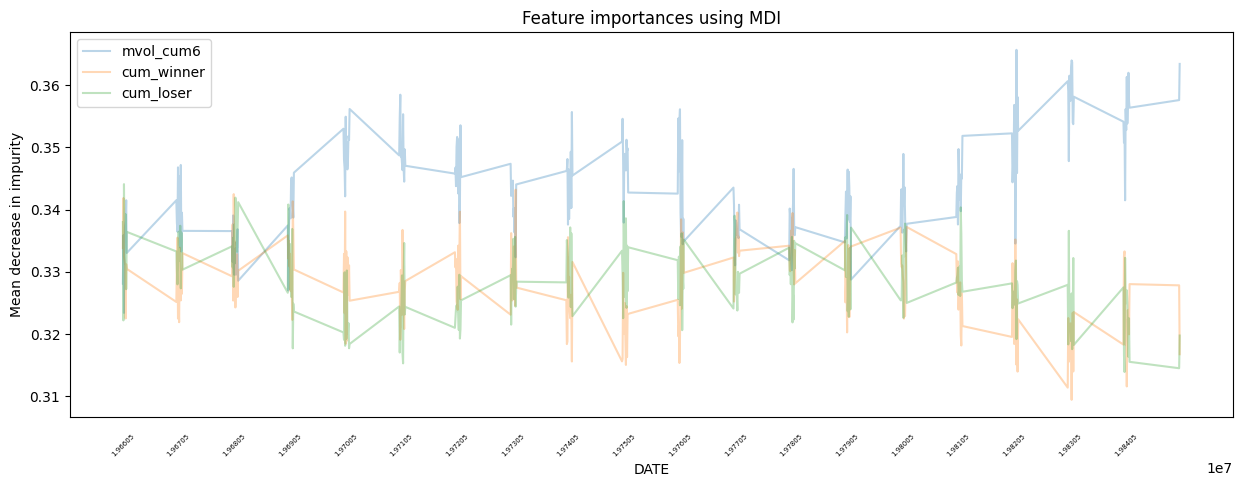

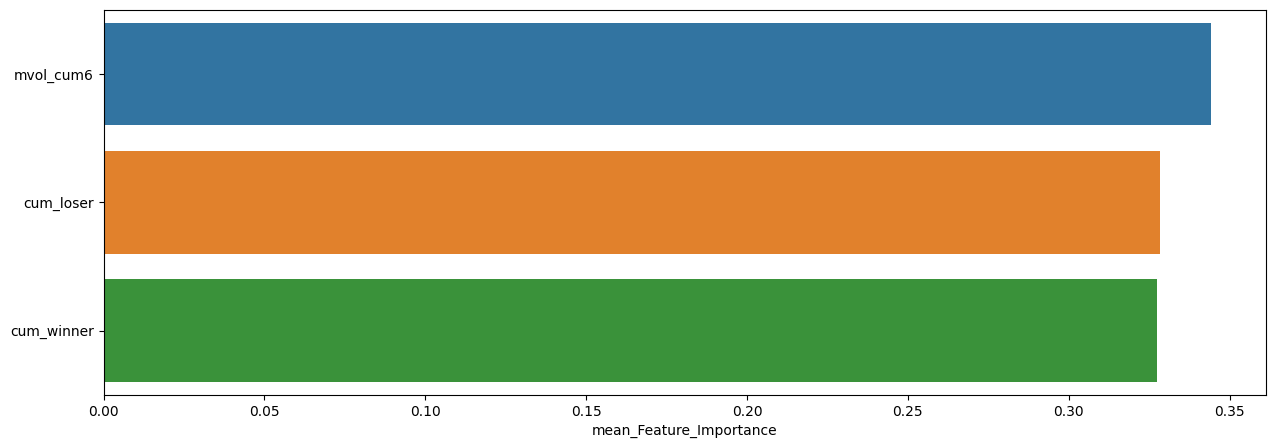

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_cum6,0.344131,0.365690,0.323422
cum_loser,0.328373,0.344110,0.313923
cum_winner,0.327496,0.343217,0.309457



**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.24      0.16      0.19        70
         1.0       0.67      0.78      0.72       156

    accuracy                           0.59       226
   macro avg       0.46      0.47      0.46       226
weighted avg       0.54      0.59      0.56       226


accuracy : 0.588495575221239

precision : 0.6740331491712708

recall : 0.782051282051282

F1-Score : 0.7240356083086054



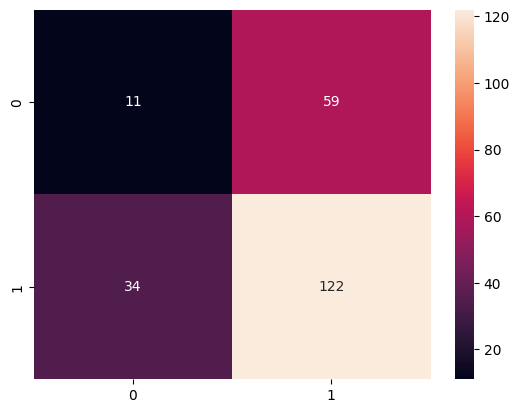


Feature Importance of the model



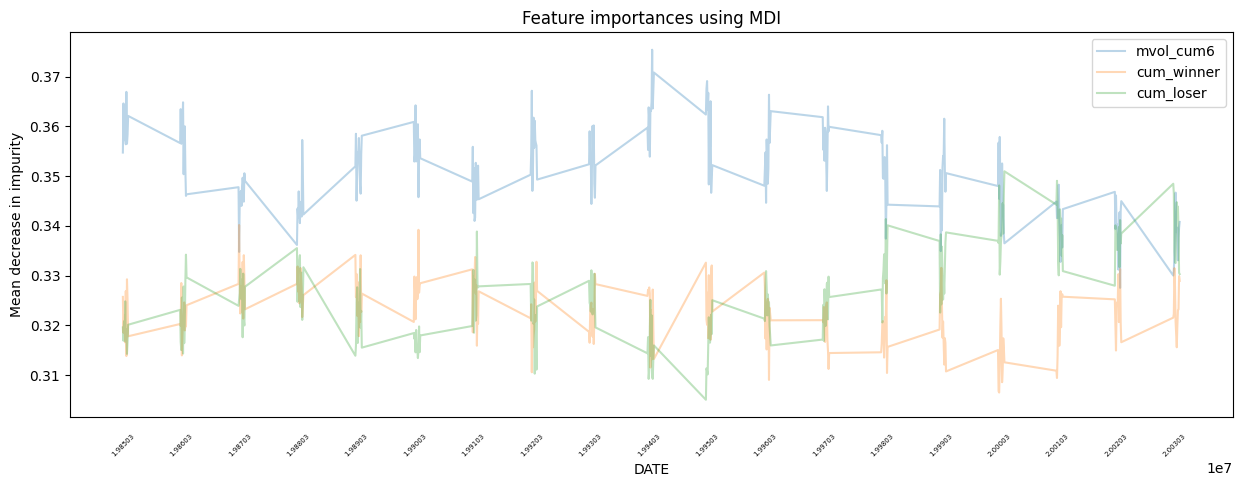

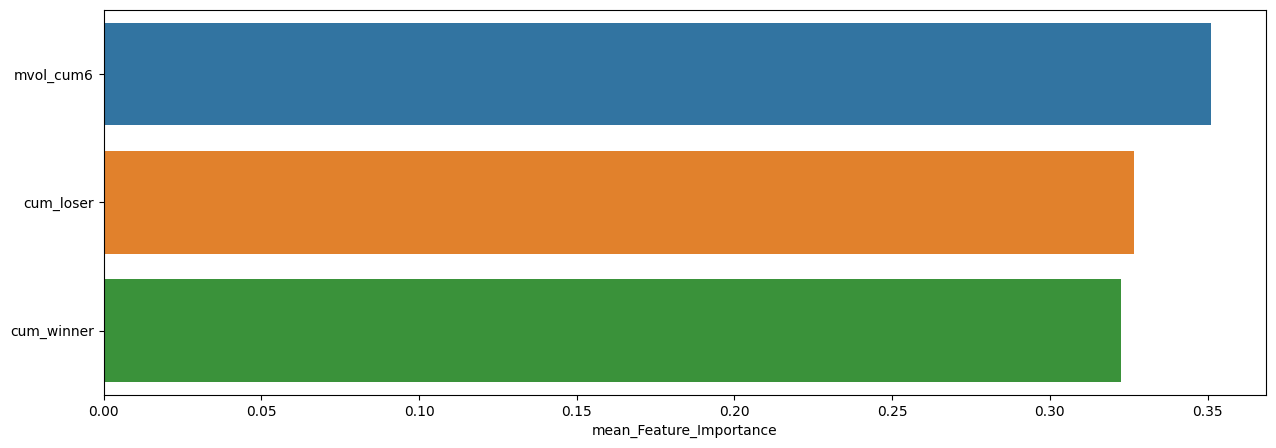

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_cum6,0.350984,0.375425,0.327526
cum_loser,0.326506,0.350972,0.305015
cum_winner,0.322510,0.340165,0.306459



**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.30      0.34        96
         1.0       0.56      0.65      0.60       132

    accuracy                           0.50       228
   macro avg       0.47      0.48      0.47       228
weighted avg       0.49      0.50      0.49       228


accuracy : 0.5043859649122807

precision : 0.5620915032679739

recall : 0.6515151515151515

F1-Score : 0.6035087719298244



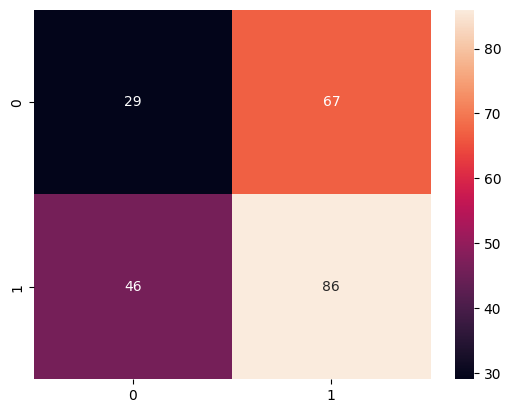


Feature Importance of the model



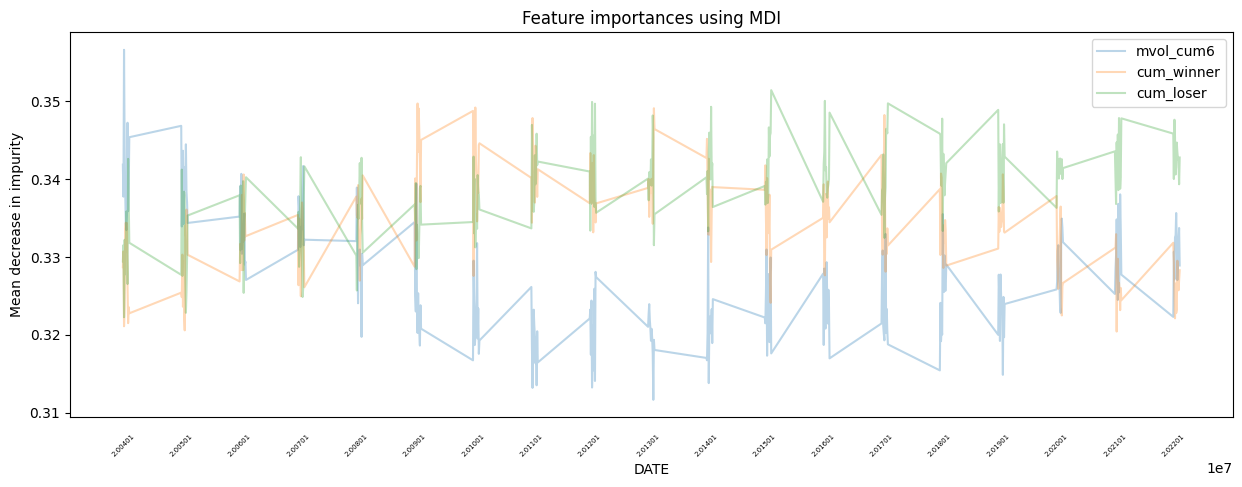

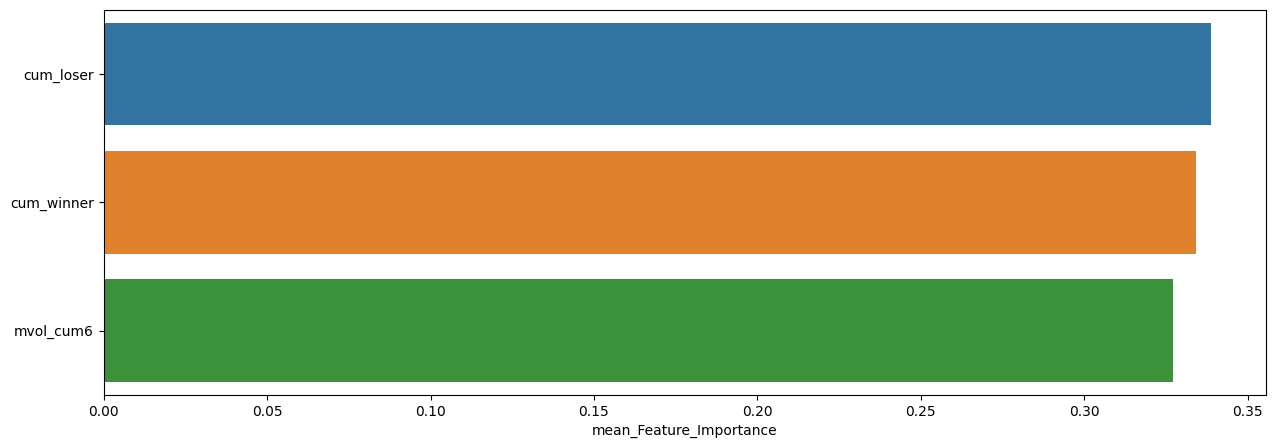

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
cum_loser,0.338676,0.351433,0.322277
cum_winner,0.334292,0.349718,0.320429
mvol_cum6,0.327033,0.356613,0.311662


In [69]:
slice_feature_importance(Fixed_RDF_Result, 4)

## Grdient Boosting

In [71]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

In [ ]:
Fixed_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GBC) 

**************************************************
설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]